# RNN from Scratch
In this notebook I am going to implement RNN using pytorch from scratch

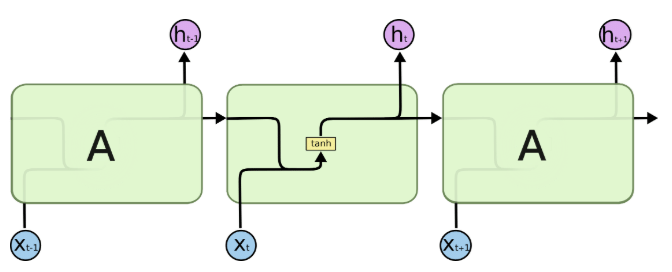

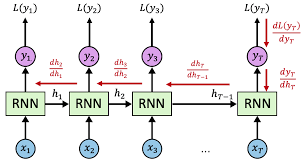

## RNN cell

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [42]:
x = torch.tensor([
            [[1., 2, 3], [11, 12, 13]],
            [[4, 5, 6], [14, 15, 16]]
        ])

x[:, 1, :]

tensor([[11., 12., 13.],
        [14., 15., 16.]])

In [43]:
x

tensor([[[ 1.,  2.,  3.],
         [11., 12., 13.]],

        [[ 4.,  5.,  6.],
         [14., 15., 16.]]])

In [44]:
w = torch.randn(3, 4)
w

tensor([[ 0.4926,  0.0369,  1.2713, -0.8272],
        [-0.5283, -0.7532,  0.6611, -0.8676],
        [-0.7577, -0.3673,  1.1971, -1.4055]])

In [45]:
torch.matmul(x[:, 1, :], w)

tensor([[-10.7716, -13.4079,  37.4805, -37.7811],
        [-13.1519, -16.6588,  46.8692, -47.0818]])

In [76]:
class BasicRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BasicRNNCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        # weight input -> hidden layer
        self.W_ih = nn.Parameter(torch.randn(hidden_size, input_size)) #hidden_size X input_size
        self.b_ih = nn.Parameter(torch.zeros(hidden_size)) # hidden_size 

        self.W_hh = nn.Parameter(torch.randn(hidden_size, hidden_size)) # hidden_size X hidden_size 
        self.b_hh = nn.Parameter(torch.zeros(hidden_size))

    def forward(self, x, h_prev): # X -> (num_batch X input_size), h_prev -> hidden_size
        hx = torch.matmul(x, self.W_ih.T) + self.b_ih # dim -> 
        hh = torch.matmul(h_prev, self.W_hh.T) + self.b_hh
        opt_add = hx + hh
        h_new = torch.tanh(opt_add)
        return h_new

**1. Weights (W_ih, W_hh, etc.) are already nn.Parameters.**
- When you later call .to(device) or .cuda() on the whole model, all parameters automatically move to that device.
- So you don’t need to do .to(device) for weights manually.

**2. The hidden state is created at runtime (not registered as a parameter).**
- Unlike model weights, h_prev is not part of the model definition—it’s initialized fresh in each forward pass.
- That means you must explicitly place it on the same device as the input.

In [77]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.rnn_cell = BasicRNNCell(input_size, hidden_size)
        self.fcc = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq): #input x -> (batch_size, seq_length, input_length)
        outputs = [] #all intermediate outputs

        self.batch_size = input_seq.size(0)
        self.seq_length = input_seq.size(1)

        # initialize hidden state for the first time step
        h_prev = torch.zeros(self.batch_size, self.hidden_size).to(input_seq.device)

        for t in range(0, self.seq_length-1):
            x = input_seq[:, t, :]
            h_prev = self.rnn_cell(x, h_prev)
            outputs.append(h_prev)

        
        final_hidden_state = outputs[-1]
        fcc_output = self.fcc(final_hidden_state)
        return outputs, fcc_output

In [78]:
x = torch.randn(2, 2, 3)
x

tensor([[[ 0.5513,  1.9902,  0.8487],
         [ 0.4283,  0.2501,  0.7806]],

        [[-0.5592, -1.1399, -0.4532],
         [ 1.2435,  0.9734,  0.2442]]])

In [79]:
rnn = SimpleRNN(3, 5, 4)

In [80]:
rnn(x)

([tensor([[ 0.9139, -0.5025,  0.5457, -0.6236,  0.9411],
          [-0.6836,  0.0783, -0.3515,  0.1294, -0.7462]],
         grad_fn=<TanhBackward0>)],
 tensor([[ 0.0878, -0.2284, -0.4436, -0.1627],
         [ 0.0813, -0.0474, -0.0203, -0.4455]], grad_fn=<AddmmBackward0>))

## Deep RNN

In [81]:
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(2, 2) for _ in range(3)])

model = MyModel()
print(list(model.parameters()))  

[Parameter containing:
tensor([[ 0.5036,  0.6165],
        [-0.0032, -0.5465]], requires_grad=True), Parameter containing:
tensor([-0.6149, -0.1452], requires_grad=True), Parameter containing:
tensor([[ 0.2896, -0.5080],
        [-0.6100,  0.3226]], requires_grad=True), Parameter containing:
tensor([-0.1623,  0.6844], requires_grad=True), Parameter containing:
tensor([[-0.0452, -0.5710],
        [-0.6854,  0.0813]], requires_grad=True), Parameter containing:
tensor([0.4535, 0.3425], requires_grad=True)]


In [82]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Linear(2, 2)

model = MyModel()
print(list(model.parameters()))  

[Parameter containing:
tensor([[-0.1235,  0.0653],
        [ 0.1050,  0.4650]], requires_grad=True), Parameter containing:
tensor([0.6589, 0.5476], requires_grad=True)]


In [108]:
class DeepRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(DeepRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.rnn_cells = nn.ModuleList()
        for layer_idx in range(self.num_layers):
            layer_input_size = input_size if layer_idx == 0 else hidden_size
            rnn_cell = BasicRNNCell(layer_input_size, hidden_size)
            self.rnn_cells.append(rnn_cell)
            
        self.fcc = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq): #input x -> (batch_size, seq_length, input_length)
        outputs = [] #all intermediate outputs

        self.batch_size = input_seq.size(0)
        self.seq_length = input_seq.size(1)

        # initialize hidden state for the first time step
        h_prevs = [torch.zeros(self.batch_size, self.hidden_size).to(input_seq.device)
                   for _ in range(self.num_layers)]
        print(h_prevs)
        for t in range(0, self.seq_length-1):
            x = input_seq[:, t, :]

            for layer_idx in range(self.num_layers):
                print(layer_idx)
                h_prevs[layer_idx] = self.rnn_cells[layer_idx](x, h_prevs[layer_idx])
                x = h_prevs[layer_idx]
            
            outputs.append(h_prevs[-1])

        
        final_hidden_state = outputs[-1]
        fcc_output = self.fcc(final_hidden_state)
        return outputs, fcc_output

In [109]:
x = torch.randn(2, 2, 3)
x

tensor([[[-2.0890,  0.5391, -1.0589],
         [-0.4403, -1.7302,  0.0778]],

        [[ 1.3574, -2.0764,  0.2127],
         [ 1.1984,  1.3025, -0.8878]]])

In [110]:
rnn = DeepRNN(3, 5, 4, 2)

In [111]:
rnn(x)

[tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]), tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])]
0
1


([tensor([[-0.9680,  0.9876, -0.3500, -0.9641,  0.9920],
          [ 0.8934, -0.9930,  0.7778,  0.9414, -0.9956]],
         grad_fn=<TanhBackward0>)],
 tensor([[ 0.0343, -0.3500,  0.8475, -0.3142],
         [ 0.3871, -0.1134, -0.7403, -0.0412]], grad_fn=<AddmmBackward0>))

In [112]:
print(list(rnn.parameters()))  

[Parameter containing:
tensor([[ 0.3739, -0.9181,  0.4878],
        [ 1.6532,  0.8488,  0.8004],
        [-0.8955,  1.7390,  1.1154],
        [-2.6128,  1.4924, -1.0881],
        [-0.7256,  0.2005,  0.9398]], requires_grad=True), Parameter containing:
tensor([0., 0., 0., 0., 0.], requires_grad=True), Parameter containing:
tensor([[-0.3830,  0.8413,  2.1346, -0.7052,  1.3731],
        [-0.9727,  1.0224, -0.3425, -1.3543,  0.7105],
        [-0.1063,  1.2921, -1.1673, -0.5311,  0.1015],
        [ 1.6865,  0.2294,  0.0211,  1.2628, -1.4024],
        [ 1.2976,  0.7801,  0.9583, -1.0618, -0.5619]], requires_grad=True), Parameter containing:
tensor([0., 0., 0., 0., 0.], requires_grad=True), Parameter containing:
tensor([[ 0.6145,  0.7800,  0.9749, -2.0867,  0.8714],
        [-1.7824,  0.2679, -0.5643,  1.3492,  0.5230],
        [ 0.8719, -0.7574,  0.5556, -0.0933, -1.2890],
        [ 0.8794,  0.4911,  0.7410, -1.4119,  0.0842],
        [-1.5952, -0.4816, -0.9505,  0.6069,  1.8657]], requires_